                            Aprendizaje No-supervisado con Modelos Generativos Profundos

                                            Fernando Arribas Jara

                                        TUTOR: Daniel Hernández Lobato

                                        UNIVERSIDAD AUTONOMA DE MADRID

Auto-Encoding Variational Bayes

![title](./Autoencoder.jpg)

Se usa una distribucion Normal MLP (Multilayer perceptron) como encoder(Apendice C: C-2 https://arxiv.org/pdf/1312.6114.pdf)


Se usa una distribucion de Bernoulli MLP como decoder(Apendice C: C-1 https://arxiv.org/pdf/1312.6114.pdf)

Como funciones de activación se han usado:

    Rectificación Lineal (RELU): Encoder y en el Decoder en su primera capa

    Sigmoide: decoder en su capa de salida
    
    Exponencial: Salida de las varianzas
    
Para inicializar las variables me he basado en este paper, concretamente la seccion 4.6.
http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf  que dice:

![title](./InicializarVar.jpg)


También he usado este paper para elegir las funciones de activación.

Como funcion de activación en la capa de salida he usado una funcion sigmoide para que los pixeles valan o bién 0 o 1.


El objetivo es maximizar el ELBO en esta expresión para asi hacer muy pequeña la divergencia KL entre las dos distribuciones que queremos aproximar (Back box varitional inference: https://arxiv.org/pdf/1401.0118.pdf) y por consiguiente mejorar Log P(x):


\begin{equation*}
\log(P_{\Theta}(x^{i})) = D_KL(q_{\Phi}(z|x^{i}) || p_{\Theta}(z|x^{i})) + \underbrace{\mathscr{L}(\Theta, \Phi; x^{i})}_{ELBO} 
\end{equation*}

Dos redes neuronales

1) Encoder: Queremos inferir P(z|x) usando
\begin{equation*}
Q(z|x, \Phi)
\end{equation*}

Nos devuelve una media y una varianza por cada dimension.

2) Muestreo de z

Realizamos el muestreo sabiendo que \begin{equation*} X \sim \mathcal{N}(\mu,\,\sigma^{2})\ \end{equation*}
Posteriormente 
aplicamos el truco de la re-parametrizacion para sacar fuera de la red todo
lo que no es diferenciable y poder calcular el gradiente por retropropagación.
\begin{equation*}
z = \mu + exp(\sigma^{2}/2)*\in
\end{equation*}

NOTA:
Cogemos \begin{equation*}
\log(\sigma^{2})
\end{equation*} porque se ha demostrado que es mejor usar exp en lugar de log ya que es numericamente más estable.Esto se usa tanto aqui como a la hora de calcular la divergencia KL.He probado ambas formas y tomando log se obtienen mejores resultados

3) Decoder:
\begin{equation*}
P(x|z, \Theta)
\end{equation*}

Generación de datos dada la variable latente z

CODIGO

Importo modulos necesarios y evito warning molestos

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

Importar dataset Face Frey

In [2]:
import os
from urllib.request import urlopen
from scipy.io import loadmat
import gzip
import pickle

num_images = 1900

with open('freyfaces.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin'
    data = u.load()

data = data.reshape((-1, 28, 20))

tam_imagen = 28 * 20
Train = data[:1600].reshape((1600, tam_imagen))
Test = data[1600:1900].reshape((300, tam_imagen))

Creo las varibles con los parametros de configuración del modelo

In [3]:
#Variables de Train
num_epocas =1000
batch_size = 100
learning_rate = 1e-3
n_datos = 1600
num_batch = int(n_datos / batch_size)
#Variables del dataset
tam_imagen = 560 # Imagenes de 28x20 pixels
tam_latente = 2
tam_hidden_layer = 500

#Creo las variables de entrada del modelo (Input -> Imagenes)

In [4]:
x = tf.placeholder(tf.float32, shape=[None, tam_imagen]) #Entrada de datos, imagenes

MODELO

Primera capa: ENCODER

In [5]:
#Semilla aleatoria
tf.set_random_seed(0)
#Pesos y biases
#Primera capa oculta
W_encoder1 = tf.Variable(tf.random_normal([tam_imagen, tam_hidden_layer], stddev= tf.pow(float(tam_imagen), -0.5)))
b_encoder1 = tf.Variable(tf.random_normal([tam_hidden_layer], stddev= tf.pow(float(tam_hidden_layer), -0.5)))

#Segunda capa: salida encoder
W_encoder_out = tf.Variable(tf.random_normal([tam_hidden_layer, tam_hidden_layer], stddev= tf.pow(float(tam_hidden_layer), -0.5)))
b_encoder_out = tf.Variable(tf.random_normal([tam_hidden_layer], stddev= tf.pow(float(tam_hidden_layer), -0.5)))

W_z_var = tf.Variable(tf.random_normal([tam_hidden_layer,tam_latente], stddev=tf.pow(float(tam_hidden_layer), -0.5)))
b_z_var = tf.Variable(tf.random_normal([tam_latente], stddev=tf.pow(float(tam_latente), -0.5)))

W_z_mean = tf.Variable(tf.random_normal([tam_hidden_layer,tam_latente], stddev=tf.pow(float(tam_hidden_layer), -0.5)))
b_z_mean = tf.Variable(tf.random_normal([tam_latente], stddev=tf.pow(float(tam_latente), -0.5)))

#Model del Encoder
encoder_capa1 = tf.matmul(x, W_encoder1) + b_encoder1
encoder_capa1 = tf.nn.relu(encoder_capa1)
encoder_out = tf.matmul(encoder_capa1, W_encoder_out) + b_encoder_out
encoder_out = tf.nn.relu(encoder_out)

Segunda capa: Muestreo de Z

In [6]:
#Mean
z_mean = tf.matmul(encoder_out,W_z_mean)+b_z_mean
#Std
z_var = tf.matmul(encoder_out, W_z_var)+b_z_var

epsilon = tf.random_normal(tf.shape(z_mean),mean=0.0,stddev=1.0,dtype=tf.float32)
z = z_mean + (tf.multiply(tf.sqrt(tf.exp(z_var)),epsilon))

Tercera capa: DECODER

In [7]:
#Pesos y biases
#Primera capa oculta
W_decoder1 = tf.Variable(tf.random_normal([tam_latente, tam_hidden_layer], stddev=tf.pow(float(tam_latente), -0.5)))
b_decoder1 = tf.Variable(tf.random_normal([tam_hidden_layer], stddev= tf.pow(float(tam_hidden_layer), -0.5)))

#Segunda capa oculta
W_decoder2 = tf.Variable(tf.random_normal([tam_hidden_layer, tam_hidden_layer], stddev= tf.pow(float(tam_hidden_layer), -0.5)))
b_decoder2 = tf.Variable(tf.random_normal([tam_hidden_layer], stddev= tf.pow(float(tam_hidden_layer), -0.5)))

W_decoder_out = tf.Variable(tf.random_normal([tam_hidden_layer, tam_imagen], stddev=tf.pow(float(tam_hidden_layer), -0.5)))
b_decoder_out = tf.Variable(tf.random_normal([tam_imagen], stddev= tf.pow(float(tam_imagen), -0.5)))

#Model del Decoder
decoder_capa1 = tf.matmul(z, W_decoder1) + b_decoder1
decoder_capa1 = tf.nn.relu(decoder_capa1)
decoder_capa2 = tf.matmul(decoder_capa1, W_decoder2) + b_decoder2
decoder_capa2 = tf.nn.relu(decoder_capa2)
decoder_out = tf.matmul(decoder_capa2, W_decoder_out) + b_decoder_out
decoder_out = tf.nn.sigmoid(decoder_out)

ELBO

\begin{equation*}
\underbrace{\mathscr{L}(\Theta, \Phi; x^{i})}_{ELBO} = -D_KL(q_{\Phi}(z|x^{i}) || p_{\Theta}(z|x^{i})) + \log(P_{\Theta}(x^{i})) 
\end{equation*}

Donde:  
\begin{equation*}
-D_KL(q_{\Phi}(z|x^{i}) || p_{\Theta}(z|x^{i})) = \frac{1}{2}\sum_{j=1}^J (1 + \log(\sigma_{j}^2) - \mu_{j}^2 - \sigma_{j}^2)
\end{equation*}

\begin{equation*}
\log(p(x|z)) = \sum_{i=1}^D x_{i}logy_{i} + (1- x_{i}). log(1-y_{i})
\end{equation*}


Nota:

En la divergencia KL usamos \begin{equation*}
\log(\sigma^{2})
\end{equation*} porque se ha demostrado que es mejor usar exp en lugar de log ya que es numericamente más estable.

En cambio en la expresión \begin{equation*}
\log(p(x|z))
\end{equation*} no es posible de ahí que se defina un min y un max (tf.clip_by_value) para evitar evaluar un log(0) que daria error.

In [8]:
#Para evitar que que el calculo de gradientes de error cuando los logaritmos son log(x) con x~0 se suma un sesgo  1e-9
decoder_out = tf.clip_by_value(decoder_out, 1e-9, 1 - 1e-9)
likelihood = tf.reduce_sum(x * tf.log(decoder_out) + (1 - x) * tf.log(1 - decoder_out), 1)
#Divergencia KL:  -D_KL(q(z)||p(z))
KL = (1/2) * tf.reduce_sum(1 + z_var - tf.square(z_mean) - tf.exp(z_var), 1)

#El likelihood se escala al tam de los batches
ELBO =  tf.reduce_mean(KL + likelihood)

Funcion de coste en la que maximizamos el ELBO

In [9]:
#Como nuestro objetivo es maximizar el ELBO vamos en sentido positivo al gradiente 
function_coste = -ELBO

Optimizador Adam (https://arxiv.org/pdf/1412.6980.pdf)

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-08)
train_step = optimizer.minimize(function_coste)

ENTRENAMIENTO

In [11]:
def generadorTest(epoca,ejemplos_test):
        decoder_capa1 = tf.matmul(z, W_decoder1) + b_decoder1
        decoder_capa1 = tf.nn.relu(decoder_capa1)
        decoder_capa2 = tf.matmul(decoder_capa1, W_decoder2) + b_decoder2
        decoder_capa2 = tf.nn.relu(decoder_capa2)
        decoder_out = tf.matmul(decoder_capa2, W_decoder_out) + b_decoder_out
        decoder_out = tf.nn.sigmoid(decoder_out)        
        datos = session.run(decoder_out, feed_dict={x: ejemplos_test})
        if(epoca ==0):
            plt.subplot(((num_epocas/100)//10) +1,10,1)
            plt.title("Input")
            img = plt.imshow(ejemplos_test[0].reshape(28, 20))            
            img.set_cmap('binary')
            plt.axis('off')
            plt.subplot(((num_epocas/100)//10) +1,10,2)
            plt.title("    Decoder")
            img = plt.imshow(datos[0].reshape(28, 20))
            img.set_cmap('binary')
            plt.axis('off')
        else:
            plt.subplot(((num_epocas/100)//10) +1 ,10,epoca + 2)
            img = plt.imshow(datos[0].reshape(28, 20))
            img.set_cmap('binary')
            plt.axis('off')

Entrenamiento
Epoca: 100 Tiempo: 0.407690  Loss= 350.949242
Epoca: 200 Tiempo: 0.375036  Loss= 350.168257
Epoca: 300 Tiempo: 0.406267  Loss= 350.033113
Epoca: 400 Tiempo: 0.439906  Loss= 350.139278
Epoca: 500 Tiempo: 0.437285  Loss= 349.059999
Epoca: 600 Tiempo: 0.436301  Loss= 348.961367
Epoca: 700 Tiempo: 0.450295  Loss= 348.312843
Epoca: 800 Tiempo: 0.463313  Loss= 348.081236
Epoca: 900 Tiempo: 0.422282  Loss= 347.903923
Epoca: 1000 Tiempo: 0.554365  Loss= 347.798731

Test con 2-D latentes, Numero de epocas 1000, Tasa de Aprendizaje 0.001000  y Tam Capas Ocultas 500

DECODIFICACION

Input


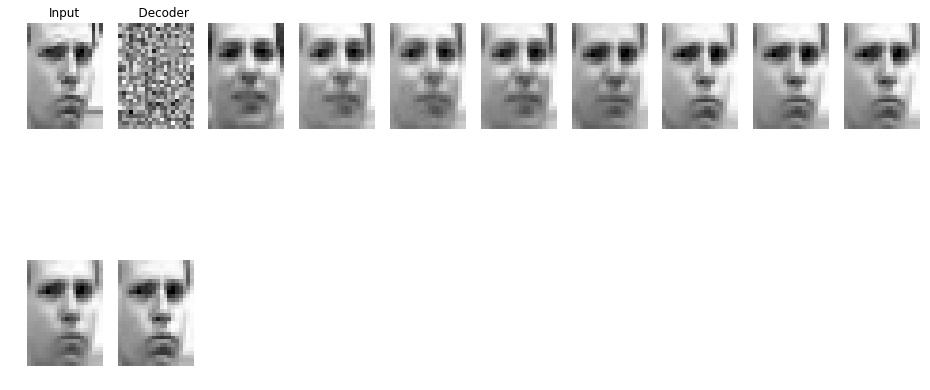

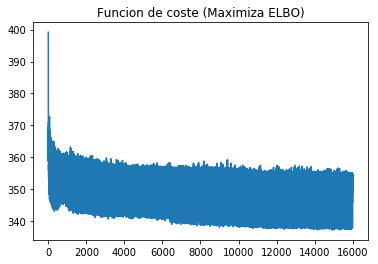

In [12]:
print('Entrenamiento')
session = tf.InteractiveSession()
tf.global_variables_initializer().run()

valores_coste = []
batches = np.split(Train, num_batch)
plt.figure(figsize=(16, 8))
generadorTest(0,Test)
num_plot = 1
for epoca in range(1, num_epocas+1):
    average_coste = 0
    inicio = time.time()
    for i in range(num_batch):            
        batch = batches[i]        
        _, coste = session.run([train_step, function_coste], feed_dict = {x: batch} )
        average_coste = (average_coste + coste)
        valores_coste.append(coste)
    fin = time.time()
    tiempo = fin - inicio    
    if epoca % 100 == 0:
        print('Epoca: %d Tiempo: %f  Loss= %f' % (epoca,tiempo,average_coste/num_batch))
        generadorTest(num_plot,Test)
        num_plot += 1


print('\nTest con %d-D latentes, Numero de epocas %d, Tasa de Aprendizaje %f  y Tam Capas Ocultas %d' % (tam_latente, num_epocas,learning_rate,tam_hidden_layer))
print ("\nDECODIFICACION")
print ("\nInput")
plt.figure()
plt.title("Funcion de coste (Maximiza ELBO)")
plt.plot(valores_coste)
plt.show()

Visualización

Dispersión del espacio latente de 2D 

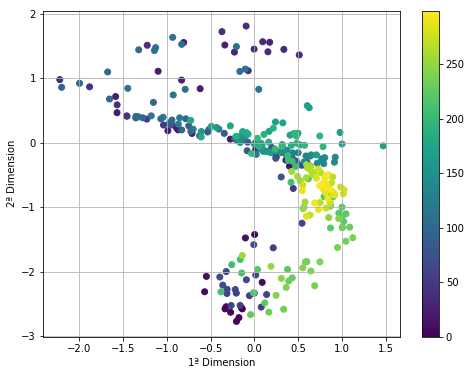

In [13]:
batches = Test
input_encoder_2d = tf.placeholder(tf.float32, shape=[None, tam_imagen])
encoder_capa1 = tf.matmul(input_encoder_2d, W_encoder1) + b_encoder1
encoder_capa1 = tf.nn.relu(encoder_capa1)
encoder_out = tf.matmul(encoder_capa1, W_encoder_out) + b_encoder_out
encoder_out = tf.nn.relu(encoder_out)
encoder = session.run(encoder_out, feed_dict={input_encoder_2d: batches})
z_mean =tf.matmul(encoder,W_z_mean)+b_z_mean
mean = session.run(z_mean, feed_dict={input_encoder_2d: batches})

plt.figure(figsize=(8, 6)) 
plt.scatter(mean[:, 0], mean[:, 1], c=np.arange(300))
plt.xlabel('1ª Dimension') 
plt.ylabel('2ª Dimension')
plt.colorbar()
plt.grid()

Manifold FREY FACE

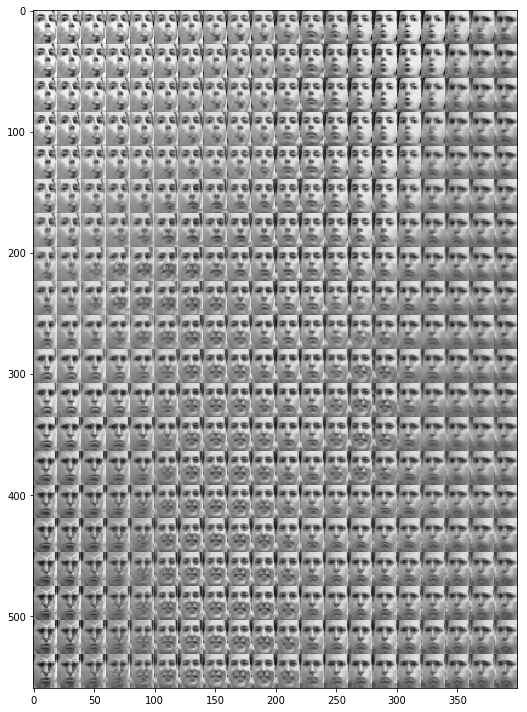

In [14]:
n = 20
primera_dim = np.linspace(-3,3, n)
segunda_dim = np.linspace(-3,3, n)
z_test = tf.placeholder(tf.float32, shape=[None, tam_latente])
canvas = np.empty((28*n, 20*n))
for i, primera in enumerate(primera_dim):
    for j, segunda in enumerate(segunda_dim):
        z_mu = np.array([[primera, segunda]]*batch_size)            
        decoder_capa1 = tf.matmul(z_test, W_decoder1) + b_decoder1
        decoder_capa1 = tf.nn.relu(decoder_capa1)
        decoder_capa2 = tf.matmul(decoder_capa1, W_decoder2) + b_decoder2
        decoder_capa2 = tf.nn.relu(decoder_capa2)
        decoder_out = tf.matmul(decoder_capa2, W_decoder_out) + b_decoder_out
        decoder_out = tf.nn.sigmoid(decoder_out)           
        imagenes_generadas = session.run(decoder_out, feed_dict={z_test: z_mu})
        canvas[(n-i-1)*28:(n-i)*28, j*20:(j+1)*20] = imagenes_generadas[0].reshape(28, 20)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(primera_dim, segunda_dim)
plt.imshow(canvas,cmap="binary", origin="upper")
plt.tight_layout()

2-D Latentes Interactivo

In [15]:
%matplotlib inline
from ipywidgets import interactive, Layout

z_test = tf.placeholder(tf.float32, shape=[None, tam_latente])
def generador(primera_dimension, segunda_dimension):
    ejemplo = np.array([[primera_dimension, segunda_dimension]]*batch_size) 
    decoder_capa1 = tf.matmul(z_test, W_decoder1) + b_decoder1
    decoder_capa1 = tf.nn.relu(decoder_capa1)
    decoder_capa2 = tf.matmul(decoder_capa1, W_decoder2) + b_decoder2
    decoder_capa2 = tf.nn.relu(decoder_capa2)
    decoder_out = tf.matmul(decoder_capa2, W_decoder_out) + b_decoder_out
    decoder_out = tf.nn.sigmoid(decoder_out) 
    imagenes_generadas = session.run(decoder_out, feed_dict={z_test: ejemplo})
    imagen = imagenes_generadas[0].reshape(28, 20)
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.imshow(imagen, cmap="binary")
    plt.axis("off")

plot = interactive(generador, primera_dimension=(-3, 3,0.01), segunda_dimension=(-3, 3, 0.01))
output = plot.children[0]
output.layout.width = '600px'
output.description='Primera dimension'
output.style = {'description_width': 'initial'}
output = plot.children[1]
output.layout.width = '600px'
output.description='Segunda dimension'
output.style = {'description_width': 'initial'}
plot

interactive(children=(FloatSlider(value=0.0, description='Primera dimension', layout=Layout(width='600px'), max=3.0, min=-3.0, step=0.01, style=SliderStyle(description_width='initial')), FloatSlider(value=0.0, description='Segunda dimension', layout=Layout(width='600px'), max=3.0, min=-3.0, step=0.01, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))